## Scraping NBA team information from Wikipedia

We are going to scrape some basic [NBA team information from Wikipedia](https://en.wikipedia.org/wiki/National_Basketball_Association#Teams). In particular, we are going to scrape the table listing each team's division, city, arena information, the year the team joined the NBA, and the current head coach.

Before we get started, it's worth pointing out that for a table this small, you don't really need to build an automated web scraper. You could just copy the data to a spreadsheet and save it to your computer for use in later analysis. Sometimes manual labor is the right solution. In this case, the small data size and relatively simple structure make this an ideal example for learning the basics of web scraping.

Let's get started.

### Importing Libraries

It's good Python practice to put all your `import` statements at the beginning of your code. That way, if you or somebody else needs to figure out which packages are used in your code, they're easy to find.

First come some imports from the Python standard library.

In [1]:
import csv
from collections import Counter, namedtuple
from pathlib import Path

We are going to use IPython's rich [`display`](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html) functionality to embed screenshots in this notebook.

In [2]:
from IPython.display import Image

We are going to use [Requests](http://docs.python-requests.org/en/master/) and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) for web scraping.

In [3]:
import requests
from bs4 import BeautifulSoup

We are going to do our data analysis using [`pandas`](https://pandas.pydata.org/), which is built on top of the [`numpy`](http://www.numpy.org/) package. These are among the most popular and central libraries in the Python ecosystem. You'll see them imported in virtually every code example on this site.

In [4]:
import numpy as np
import pandas as pd

Before we start scraping, we are going to define some directory paths to allow us to access and store data and images. We are using the [`pathlib`](https://docs.python.org/3/library/pathlib.html) module from the Python standard library in order to create paths that should work on all platforms, whether you are running this on a Mac, Windows or Linux machine.

In [5]:
PARENT_DIR = Path.cwd().parent
OUTPUTS_DIR = PARENT_DIR / 'outputs'
IMAGES_DIR = PARENT_DIR / 'images'

We'll build a list of screenshots here in advance.

In [6]:
wiki_screenshots = [str(f) for f in list(IMAGES_DIR.glob('wiki_nba_team-screenshot-*.png'))]
len(wiki_screenshots)

5

### Getting the HTML

In order to get the Wikipedia page, Requests will need the web address, which is more formally referred to as a [_Uniform Resource Locator_](https://en.wikipedia.org/wiki/URL), or URL.

In [7]:
URL = 'https://en.wikipedia.org/wiki/National_Basketball_Association'

Now let's ask Requests to to issue a GET request for the page.

In [8]:
response = requests.get(URL, allow_redirects=False, timeout=10)

The parameters after the URL tell Requests that we don't want to allow the web site (Wikipedia in this case) to redirect us to another web page, and to not wait more than 10 seconds before returning an error if the web site is not responding.  It's good practice to always include these parameters when using Requests.

In [9]:
response.status_code

200

If you run this code on your computer, this will print out status code 200 unless a problem occured (maybe the Wikipedia website is down or the URL has changed since I wrote this).

All of the text, images, links and other content from the web page now lurk inside that object named `response`.

Let's see what sort of information Wikipedia returned.

In [10]:
response.headers['content-type']

'text/html; charset=UTF-8'

Now let's see how much text (measured by number of characters) is on the web page.

In [11]:
len(response.content)

379880

That's a lot of content. If you are trying this out on your computer and want to scroll through the whole thing, feel free to `print(response.content)`. If you do, you will see a large amount of text which probably doesn't make a lot of sense.

We are going to use BeautifulSoup to make some sense of the HTML. We are going to use the default HTML parser, which is appropriately enough named `html.parser`.

In [12]:
soup = BeautifulSoup(response.content, 'html.parser')

The `soup` object now contains all of the original HTML, but structured in a way that will make it much easier to extract the information we want.

In [13]:
soup.title

<title>National Basketball Association - Wikipedia</title>

The `<title>` and `</title>` strings are examples of [HTML _tags_](https://www.w3schools.com/tags/ref_byfunc.asp), which tell your browser about the structure and components of a document. An [HTML _element_](https://www.w3schools.com/html/html_elements.asp) typically consists of a _start tag_ (`<title>` in this example) and an _end tag_ (`</title>` in this example), with the content in between the tags.

The document structure is created by nesting elements inside other elements. We'll see an example of document structure in scraping the Wikipedia page.

To access the content without the tags, use the `text` attribute.

In [14]:
soup.title.text

'National Basketball Association - Wikipedia'

Note that this text is what the browser displays for the window or tab containing the Wikipedia page.

### Examining the HTML Tags

We can use BeautifulSoup's `find_all()` method to extract the tags we want. First, let's get all of the HTML tags from inside the `body` of the page.

In [15]:
tags = [tag.name for tag in soup.body.find_all(True)]
len(tags)

5324

There are over 5300 HTML tags representing the body of this page. Let's use the `Counter()` class from Python's standard library to count up how many of each tag type are present.

In [16]:
tag_counts = Counter(tags)
len(tag_counts)

35

There are 35 distinct tag types. Let's look at the most common ones.

In [17]:
tag_counts.most_common(15)

[('a', 1936),
 ('span', 858),
 ('td', 627),
 ('li', 618),
 ('div', 200),
 ('tr', 163),
 ('b', 110),
 ('ul', 103),
 ('dd', 103),
 ('th', 91),
 ('sup', 89),
 ('i', 88),
 ('p', 83),
 ('cite', 63),
 ('table', 38)]

In [18]:
sum([t[1] for t in tag_counts.most_common(15)])

5170

So roughly 97% of the tags on this Wikipedia page are from the above 15 tag types. This represents some progress, but it's still not obvious which elements are important to us and how we're supposed to access them.

Fortunately, it turns out that there is a relatively simple trick to immediately find the interesting elements on an HTML-rendered web page.

### Use Your Browser's Developer Tools

The trick is to use your browser's developer tools to inspect the web page's [_Document Object Model_](https://www.w3.org/TR/WD-DOM/introduction.html), or DOM. Most major browsers have tools that allow you to click on elements in the web page and jump directly to the associated HTML, to see what tags correspond to particular elements. Here's a screenshot of how it looks in my Chrome browser, as I inspect the table of NBA teams.

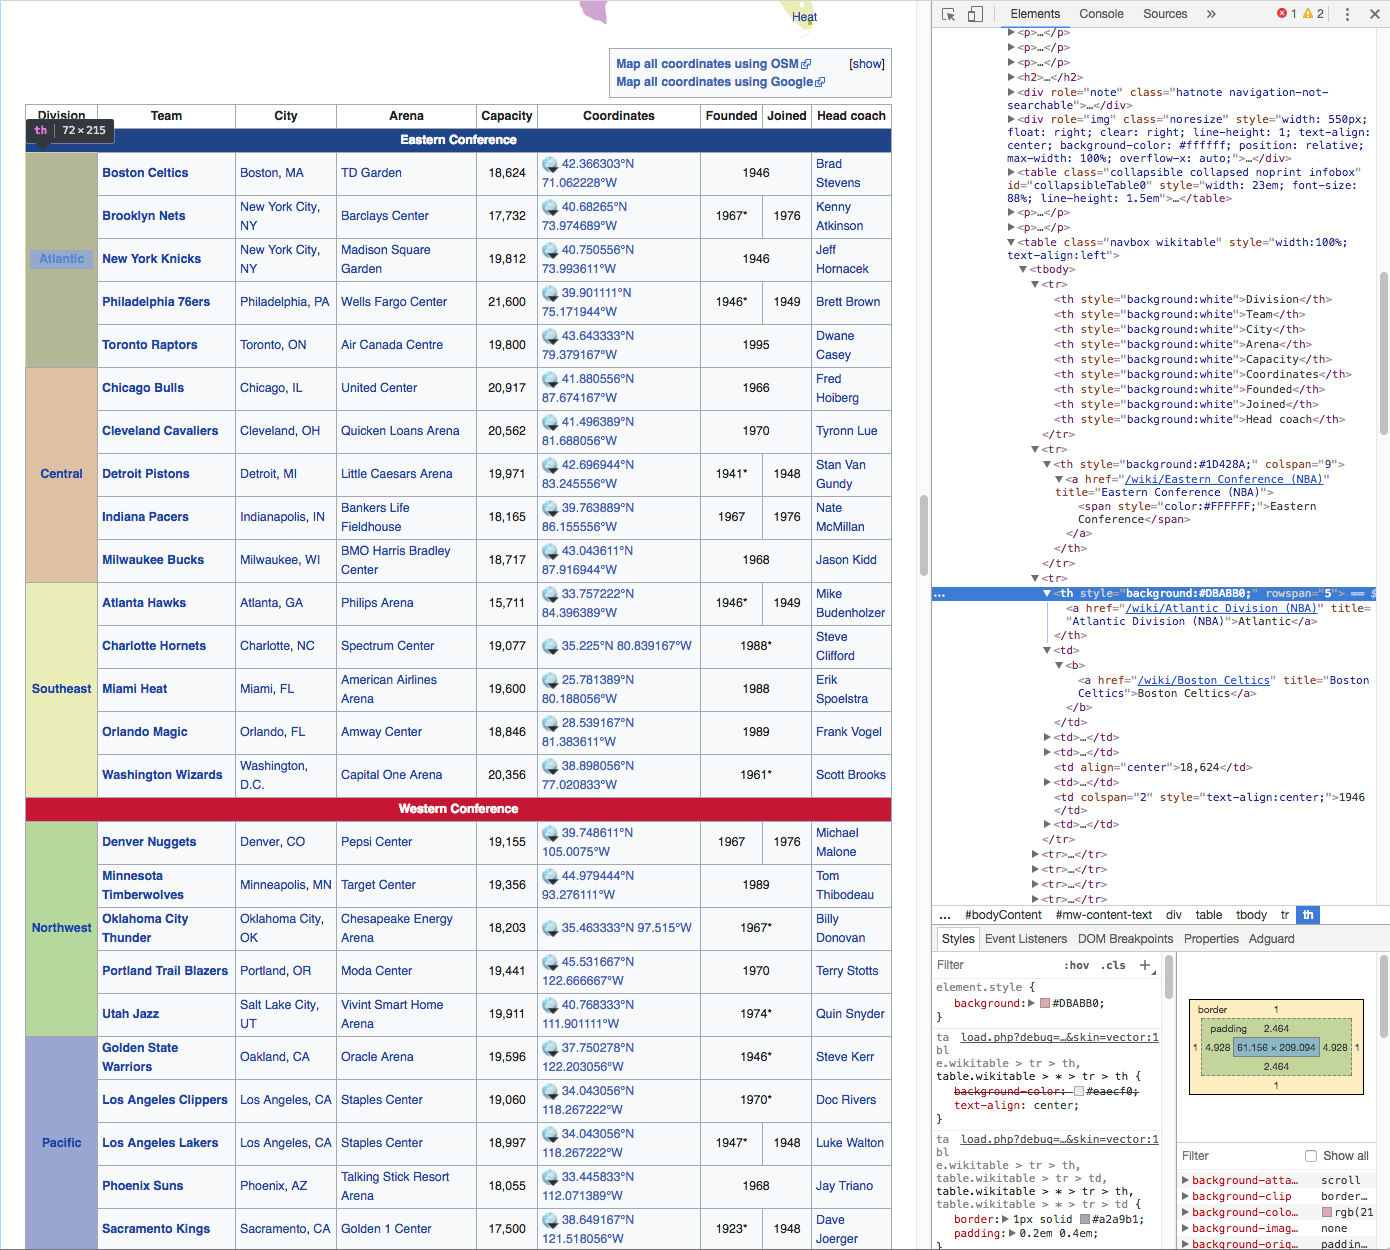

In [19]:
Image(filename=wiki_screenshots[0], embed=True)

See the [instructions for opening and using Chrome's developer tools](https://developers.google.com/web/tools/chrome-devtools/). In Chrome, you first select the **Elements** group of tools and use the "Select an element in the page to inspect it" tool (the left-most symbol, with a square and arrow, as shown in the screen shot above).

The easier way to get the same result in Chrome is to hover over an element, right-click (or control-click on a Mac), and choose **Inspect** from the menu that pops up.

Other popular browsers have their own versions of these tools which work similarly. You can read about [Safari's Web Inspector](https://developer.apple.com/library/content/documentation/NetworkingInternetWeb/Conceptual/Web_Inspector_Tutorial/EditingCode/EditingCode.html), [Firefox's Inspector](https://developer.mozilla.org/en-US/docs/Tools/Page_Inspector/How_to/Open_the_Inspector) and [Microsoft's DOM Explorer](https://msdn.microsoft.com/en-us/library/dn255008.aspx).

From the above screen shot, it's easy to see that the table we care about is inside a `<table>` tag. We saw from our `Counter` analysis above that there are 38 `<table>` tags in the page body, so which one in particular do we want?

### Extracting the Table

HTML elements can have [_attributes_](https://www.w3schools.com/html/html_attributes.asp) which provide additional information, such as `class`, `id` or `style`. According to the element inspector tool, we want the particular table having `class="navbox wikitable"`. We can specify attributes in BeautifulSoup's `find_all()` and `find()` methods to narrow down the elements we extract.

In [20]:
wikitables = soup.body.find_all('table', class_='navbox wikitable')
len(wikitables)

1

Notice that the `class_` parameter has a trailing underscore, so it's not confused with the Python reserved word `class`.

Also notice that `find_all()` returns a list of tables, which in this case happens to only have one item. From this, we know that there is only one table on this page with `class=navbox wikitable`. 

Let's continue to use the element inspector tool to see how we can work our way through the table to extract the useful information.

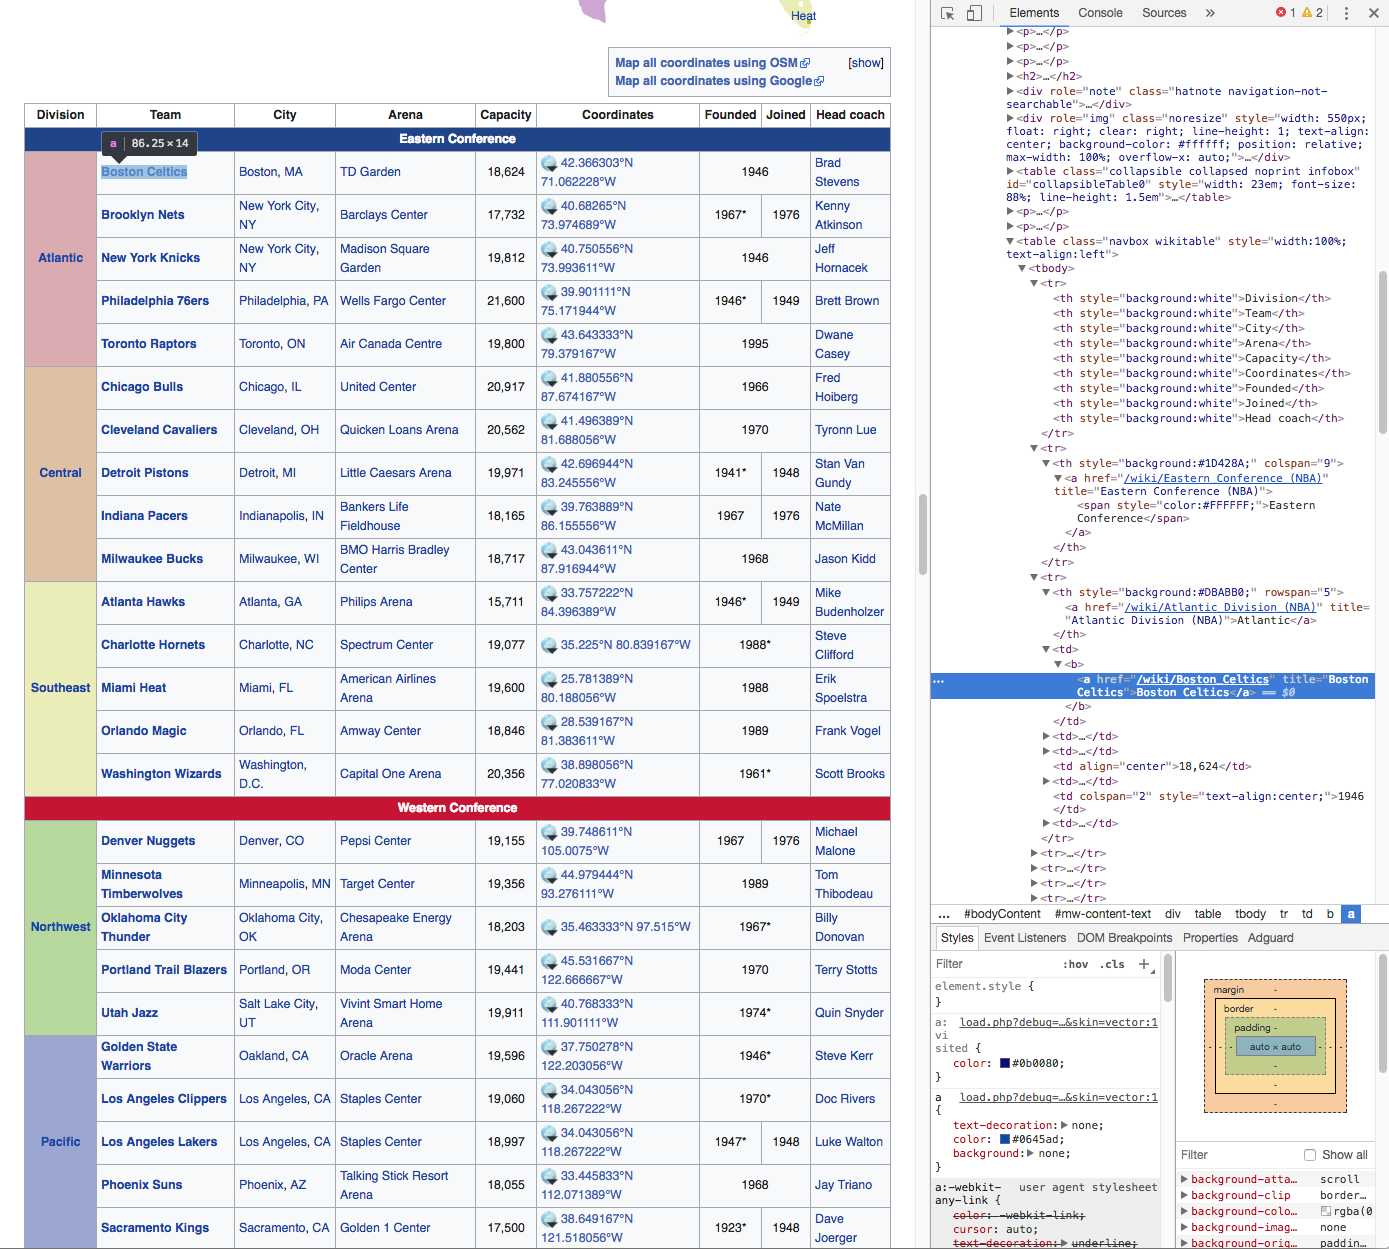

In [21]:
Image(filename=wiki_screenshots[1], embed=True)

Each row in the table is bracketed by a `<tr>` tag. The first row contains the column headers. Let's extract all the rows from the table into a new variable and work with that.

In [22]:
rows = wikitables[0].find_all('tr')
len(rows)

33

It's a good sign that there are 33 rows in our results. There are 30 NBA teams, each of which take up one row in the table. There is one extra row for the column headers, and two rows for each of the conferences, making up 33 total rows. That means the `rows` variable has all the information we need.

### Getting the Column Headers

Let's look at the first row and confirm it has the column headers.

In [23]:
rows[0]

<tr>
<th style="background:white">Division</th>
<th style="background:white">Team</th>
<th style="background:white">City</th>
<th style="background:white">Arena</th>
<th style="background:white">Capacity</th>
<th style="background:white">Coordinates</th>
<th style="background:white">Founded</th>
<th style="background:white">Joined</th>
<th style="background:white">Head coach</th>
</tr>

This confirms that the elements with the `<th>` tags are the headers. We can use `find_all()` to extract the text and save the headers in a list for later use.

In [24]:
headers = [th.text for th in rows[0].find_all('th')]
print(headers)

['Division', 'Team', 'City', 'Arena', 'Capacity', 'Coordinates', 'Founded', 'Joined', 'Head coach']


In [25]:
len(headers)

9

### Write Python Functions to Store Knowledge

We've come a long way in figuring out how to scrape this table. It's time to start putting this knowledge into Python functions. This will have a lot of benefits.

First, coding all the steps in a function **forces us to think clearly**, since we are turning over control of the process to the computer.

Second, we can reuse our function in the future. If a team builds a new arena or changes the coach, we can run our function again. It's much easier to run a function  than to remember all the steps we took. The important thing is that **writing the function documents our methods**.

This leads to the third benefit, which is that **other people can more easily replicate our analysis** if we share the function with them.

Although we're scraping a web page in this example, the general concept of using functions to store knowledge will apply to many aspects in your sports analytics projects. Each time you figure something out, take the time to record it properly in a function. You'll thank yourself every time you decide to rerun or enhance an analysis, or share it with somebody else.

Let's start by writing a small function to scrape the column headers and return them.

In [26]:
def get_headers(row):
    return [th.text for th in row.find_all('th')]

Let's test the function.

In [27]:
get_headers(rows[0])

['Division',
 'Team',
 'City',
 'Arena',
 'Capacity',
 'Coordinates',
 'Founded',
 'Joined',
 'Head coach']

This is a very easy function. However, by the time we get to the end of this post, I hope you'll see the value in creating these small, understandable functions as you go.

### Getting the Conference and Division Information

Now, let's use the element inspector tool to figure out how the get the NBA conference and division information.

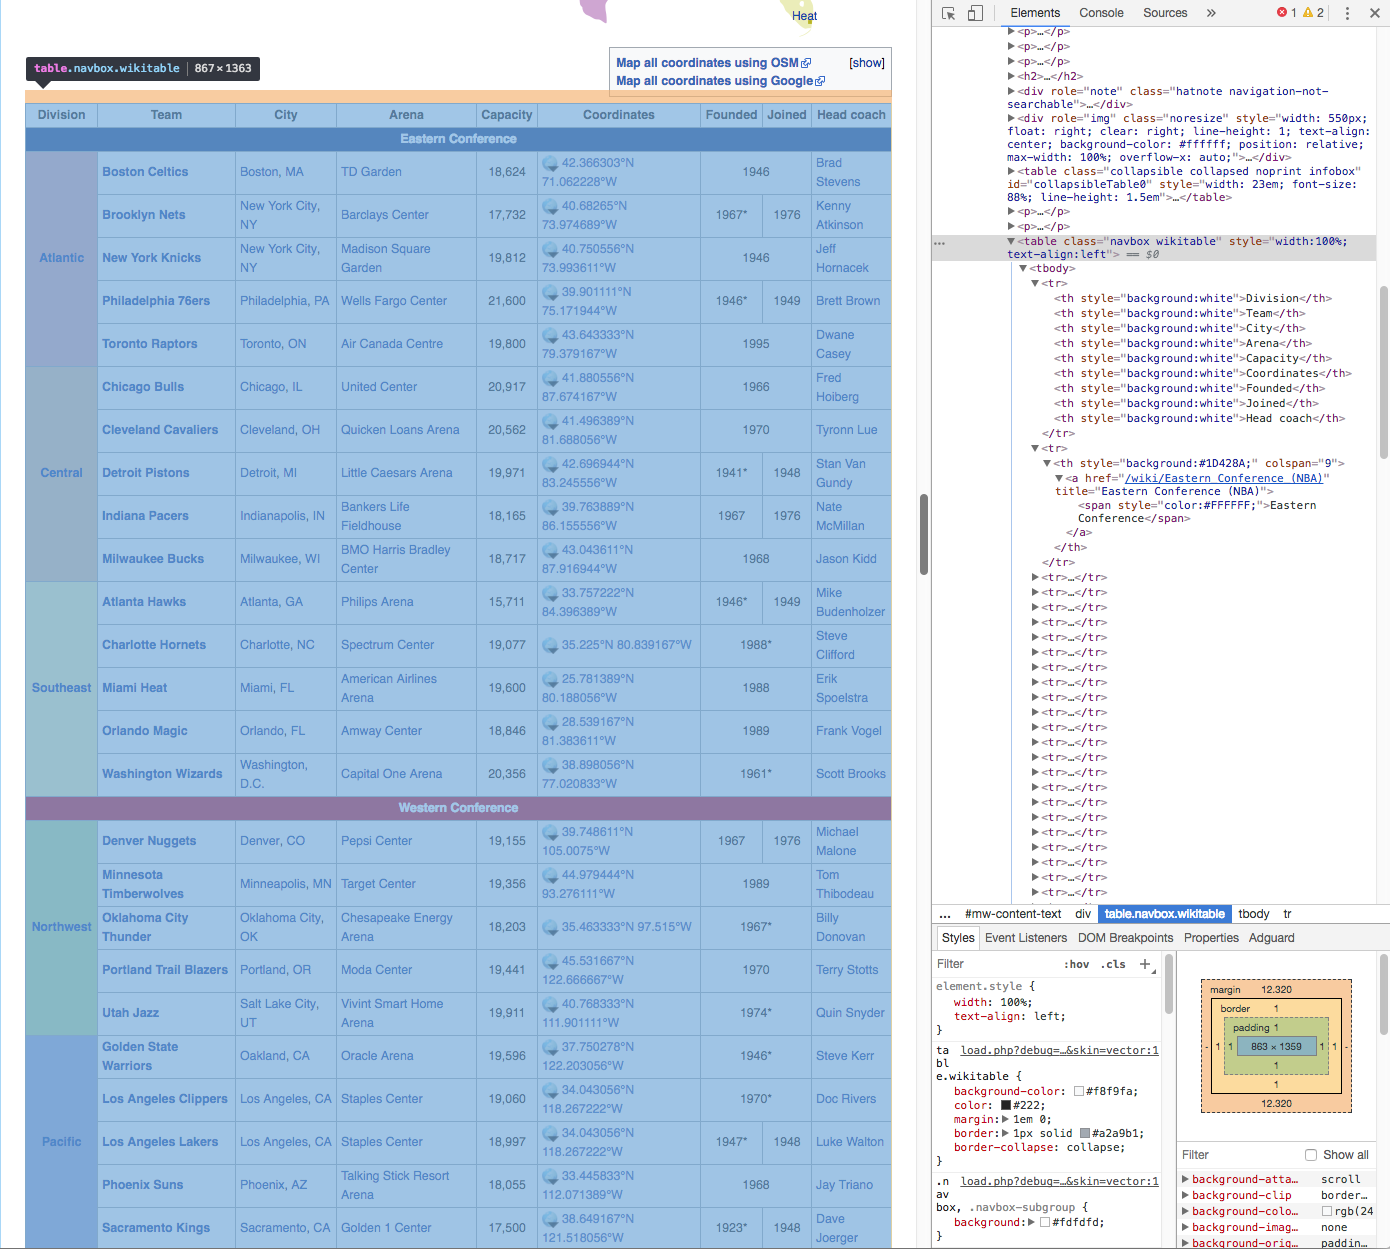

In [28]:
Image(filename=wiki_screenshots[2], embed=True)

Let's look at the second row in the table.

In [29]:
rows[1]

<tr>
<th colspan="9" style="background:#1D428A;"><a href="/wiki/Eastern_Conference_(NBA)" title="Eastern Conference (NBA)"><span style="color:#FFFFFF;">Eastern Conference</span></a></th>
</tr>

This row is relatively simple, even though it has a few elements. It has a row header with tag `<th>` that spans multiple columns to stretch across the entire table. That is the meaning of the `colspan="9"` attribute. This row also has a link (the `<a>` element) pointing to the Wikipedia page for the Eastern Conference. The text and color of the row is specified in the `<span>` element.

In [30]:
rows[1].text

'\nEastern Conference\n'

Let's write a small function to scrape the conference name, clean it up a bit, and return it.

In [31]:
def get_conference(row):
    conference = row.find('th', colspan=True)
    return conference.text.strip().split()[0] if conference else None

In [32]:
get_conference(rows[1])

'Eastern'

This function is slightly tricky, since it will return Python's special value `None` if the row doesn't have a `<th>` tag with a `colspan` attribute. This means we can be sure this function will only return a value if the row does in fact contain a conference name. Let's test that out on some different rows.

In [33]:
get_conference(rows[2])

In [34]:
get_conference(rows[17])

'Western'

The function doesn't return anything except for the two rows which contain the conference name, which is what we want.

The division information is a bit more complicated. As you can see from the screen shot below showing the Atlantic division, the division is stored in a row header (`<th>` tag). This row header has a `rowspan="5"` attribute, since each division has 5 NBA teams.

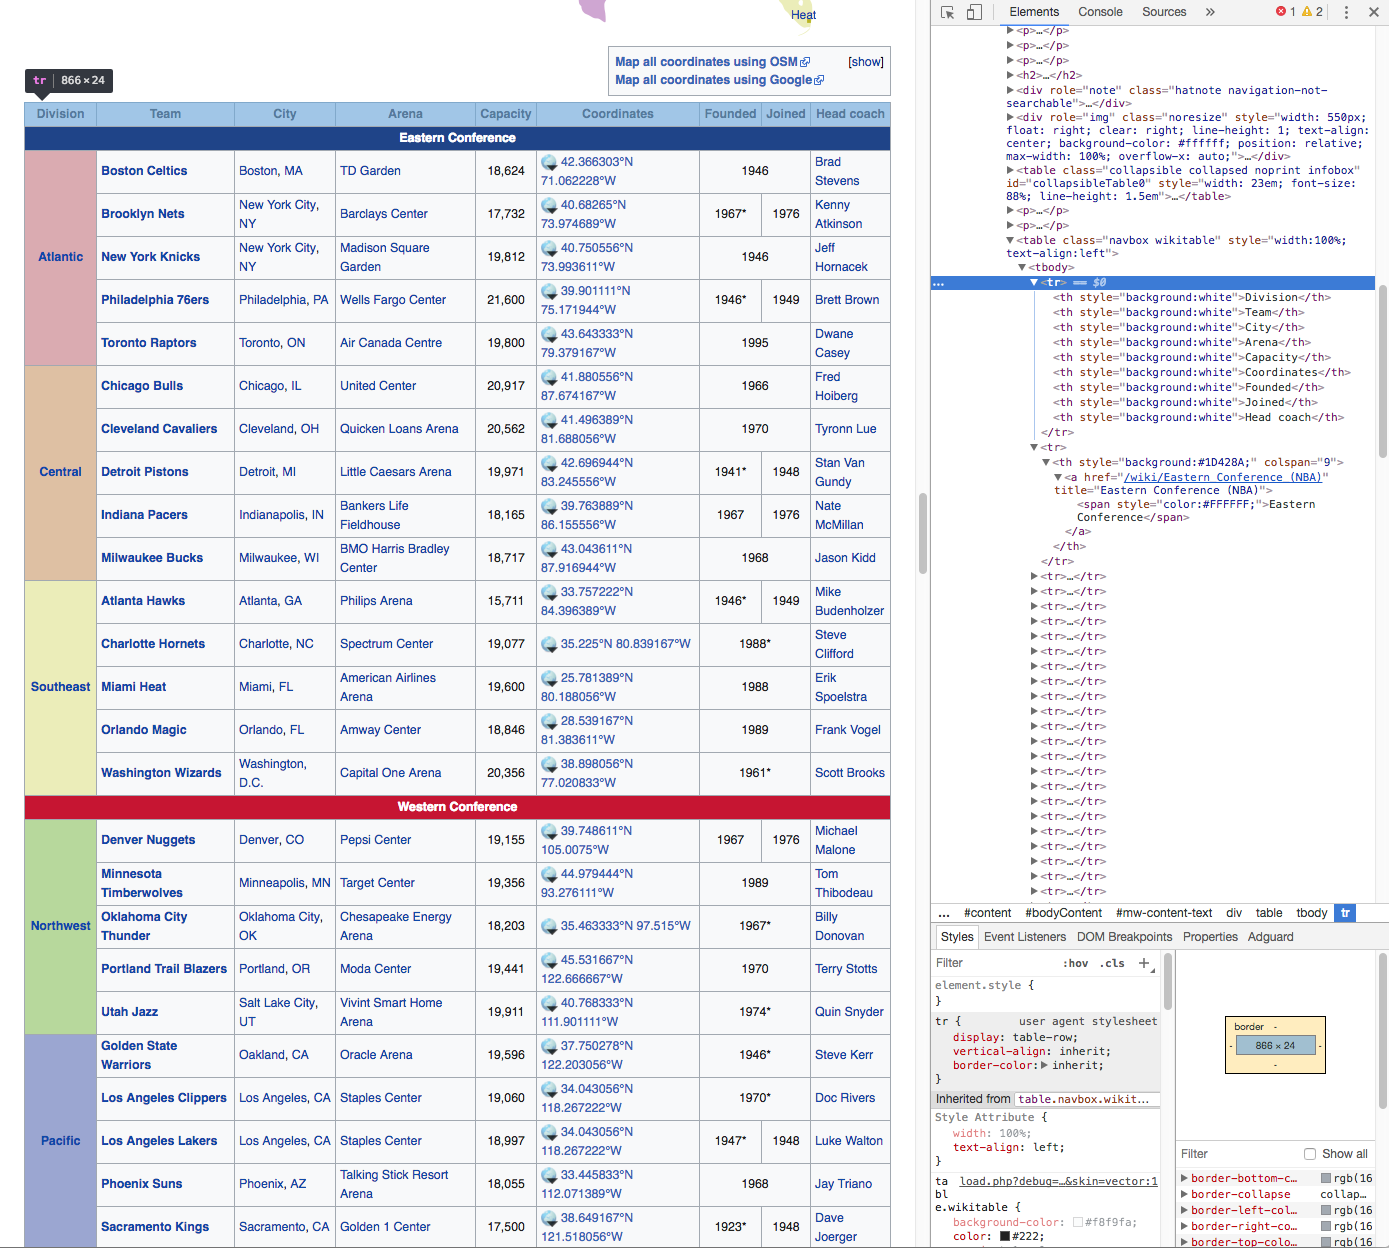

In [35]:
Image(filename=wiki_screenshots[3], embed=True)

Notice that the Atlantic division header only appears in the same row as the Boston Celtics (the first team listed in the division), even though it is displayed as covering all 5 rows because of the `rowspan="5"` attribute. This will be important later.

Let's focus first on the row header for the third row (the Celtics).

In [36]:
rows[2].find('th')

<th rowspan="5" style="background:#DBABB0;"><a href="/wiki/Atlantic_Division_(NBA)" title="Atlantic Division (NBA)">Atlantic</a></th>

We can get the division name easily using the `text` attribute.

In [37]:
rows[2].find('th').text

'Atlantic'

However, if we try this for the subsequent row (the Nets), we don't get anything back.

In [38]:
rows[3].find('th')

This shows that the division information is only available on the row containing the first team in that division. We'll need to incorporate this fact into our scraping strategy for the whole table later.

Let's write a small function to scrape the division name for a row, if it's there, and return it. Similar to the conference function above, if the row doesn't have a division name, the function will return `None`.

In [39]:
def get_division(row):
    division = row.find('th', rowspan=True)
    return division.text.strip() if division else None

Let's test out our function.

In [40]:
get_division(rows[2])

'Atlantic'

In [41]:
get_division(rows[3])

In [42]:
get_division(rows[7])

'Central'


### Understanding the Team Information

Let's move on for the moment to examine the team data in each row. From the screen shot, it's clear that the table cells correspond to `<td>` elements.

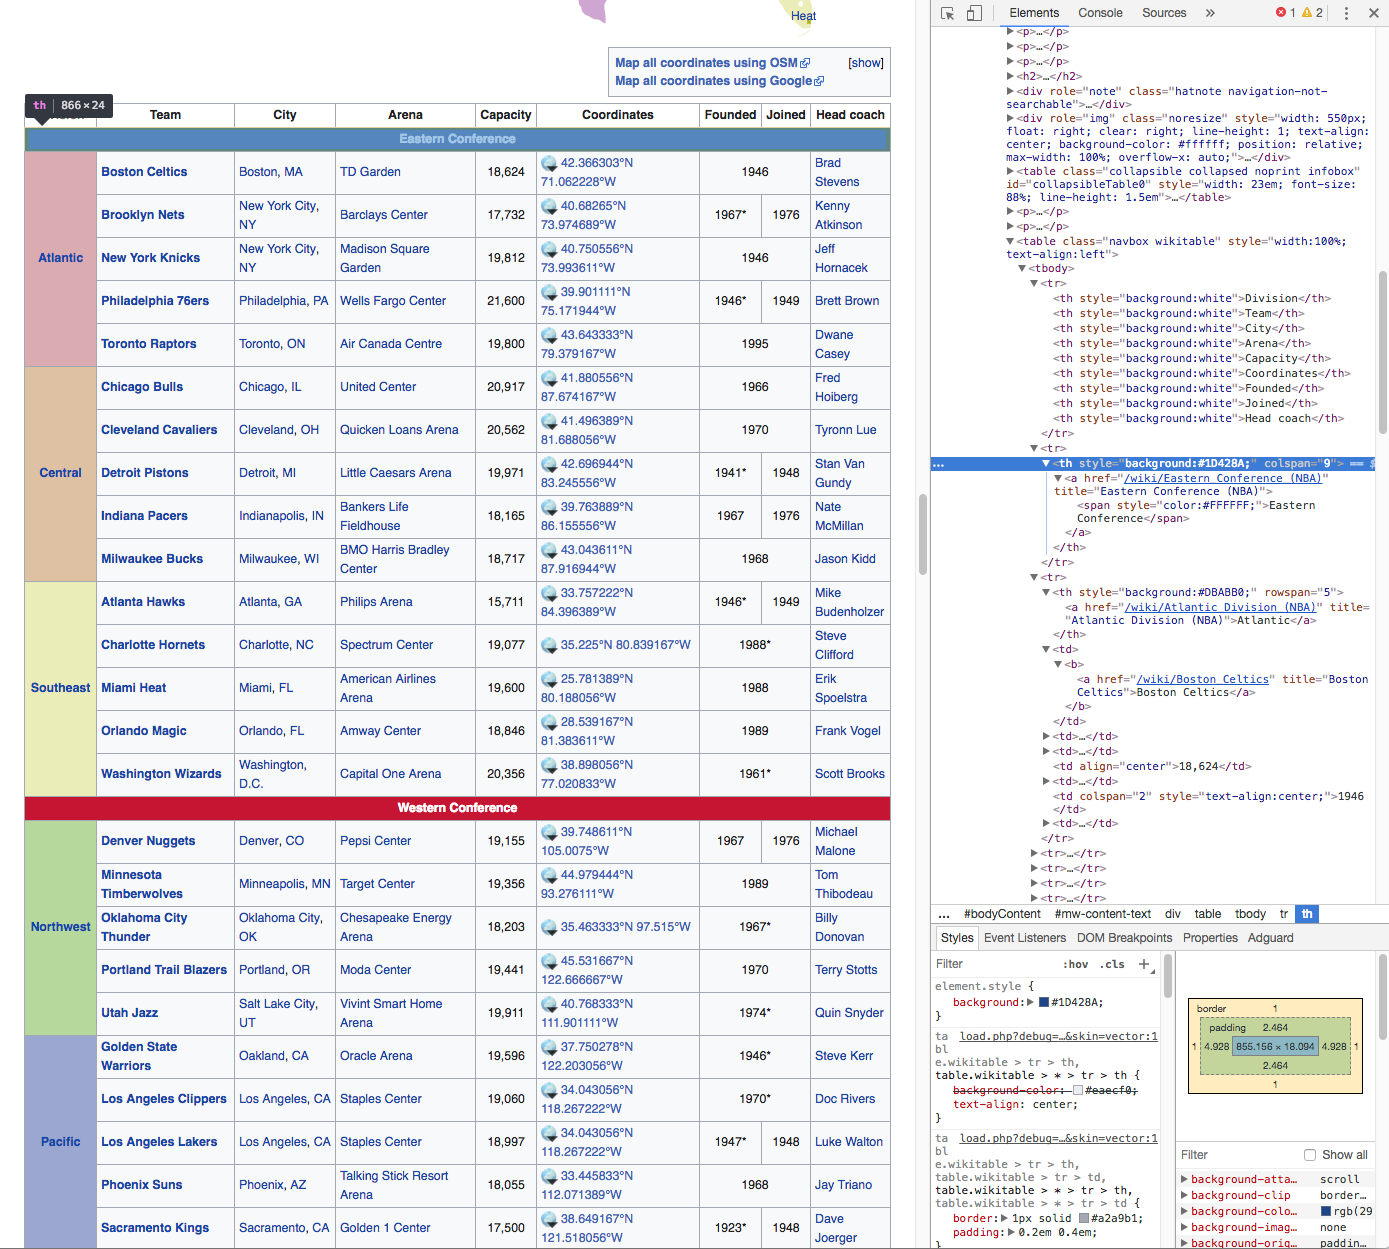

In [43]:
Image(filename=wiki_screenshots[4], embed=True)

Let's figure out how to process this structure for each team. Let's start by checking how many `<td>` tags there are in each row.

In [44]:
Counter([len(row.find_all('td')) for row in rows])

Counter({0: 3, 7: 21, 8: 9})

There are 3 rows with zero `<td>` tags, which correspond to the column header row and the two conference name rows. Those rows have no team data. Of the 30 team rows, there are 21 rows with 7 `<td>` tags, and 9 rows with 8 `<td>` tags.

The first thing to notice is that the team rows only have either 7 or 8 data fields, whereas there are 9 column headers. One of the columns is the division, which as we discussed above is actually a row header (`<tr>` tag).

The other reason for the discrepancy in column numbers is in in the "year founded" and "year joined" columns. Looking at the screen shot above, we see that an original [BAA](https://en.wikipedia.org/wiki/Basketball_Association_of_America) team such as the Celtics has one value (1946) spanning both columns, since the year joined is the same as the year founded. An ABA-NBA merger team such as the Nets has two fields with different values for year founded and year joined.

We need to be careful about the different row structures for the various teams. Even though we might not care about the year founded and year joined at this point, it's a good learning exercise to see how to scrape a table like this. 

Let's focus on the Celtics for now.

In [45]:
row = rows[2]

We can extract all the fields into a list.

In [46]:
fields = row.find_all('td')
len(fields)

7

Let's look at the fields in detail.

In [47]:
print(fields[0].prettify())

<td>
 <b>
  <a href="/wiki/Boston_Celtics" title="Boston Celtics">
   Boston Celtics
  </a>
 </b>
</td>



The first field is the team name, which is easy to extract. We will also save the Wikipedia link to the team information using the `href` attribute of the underlying `<a>` tag. Saving the Wikipedia link will be useful in case we ever decide we want to scrape the detailed Wikipedia pages for each team.

In [48]:
name = fields[0].text
name_wiki = fields[0].a['href']
name, name_wiki

('Boston Celtics', '/wiki/Boston_Celtics')

In [49]:
print(fields[1].prettify())

<td>
 <a href="/wiki/Boston" title="Boston">
  Boston
 </a>
 ,
 <a href="/wiki/Massachusetts" title="Massachusetts">
  MA
 </a>
</td>



Similarly, we can easily get the team's home city and postal code. Wikipedia stores two links to the city and state (or province in the case of Toronto), except in the case of Washington, D.C. We will only store the city Wikipedia link.

In [50]:
city, postal = fields[1].text.split(',')
postal = postal.replace('.', '') # remove periods for Washington, D.C.
city_wiki = fields[1].find_all('a')[0]['href']
city, postal, city_wiki

('Boston', ' MA', '/wiki/Boston')

In [51]:
print(fields[2].prettify())

<td>
 <a href="/wiki/TD_Garden" title="TD Garden">
  TD Garden
 </a>
</td>



Next comes the arena name and Wikipedia link, which are similar to the team name.

In [52]:
arena = fields[2].text
arena_wiki = fields[2].a['href']
arena, arena_wiki

('TD Garden', '/wiki/TD_Garden')

In [53]:
print(fields[3].prettify())

<td align="center">
 18,624
</td>



The arena capacity requires some work, since Wikipedia stores the numbers are strings with a comma as thousands separators. We need to strip out the comma and convert to a Python `int` to store the capacity as a number.

In [54]:
fields[3].text

'18,624'

In [55]:
arena_cap = int(fields[3].text.replace(',', ''))
arena_cap

18624

In [56]:
print(fields[4].prettify())

<td>
 <span class="plainlinks nourlexpansion">
  <a class="external text" href="//tools.wmflabs.org/geohack/geohack.php?pagename=National_Basketball_Association&amp;params=42.366303_N_-71.062228_E_type:landmark&amp;title=Boston+Celtics">
   <span class="geo-nondefault">
    <span class="geo-dms" title="Maps, aerial photos, and other data for this location">
     <span class="latitude">
      42°21′59″N
     </span>
     <span class="longitude">
      71°03′44″W
     </span>
    </span>
   </span>
   <span class="geo-multi-punct">
    ﻿ / ﻿
   </span>
   <span class="geo-default">
    <span class="vcard">
     <span class="geo-dec" title="Maps, aerial photos, and other data for this location">
      42.366303°N 71.062228°W
     </span>
     <span style="display:none">
      ﻿ /
      <span class="geo">
       42.366303; -71.062228
      </span>
     </span>
     <span style="display:none">
      ﻿ (
      <span class="fn org">
       Boston Celtics
      </span>
      )
     </span>
   

The arena geographic coordinates require the most work. They are stored in a `<span>` tag with `class="geo"`. We can extract the text very easily, but we have to separate the text into latitude (North/South) and longitude (East/West) and store the results as numbers with decimals (Python `float`).

In [57]:
fields[4].find('span', class_='geo').text

'42.366303; -71.062228'

In [58]:
lat, lon = (float(x) for x in fields[4].find('span', class_='geo').text.split(';'))
lat, lon

(42.366303, -71.062228)

Now we will skip to the last field, which is the coach's name. The only wrinkle in this field is that the field number will change depending upon whether the team has only a year founded, or both a year founded and a year joined. We can avoid any confusion by using Python's `[-1]` list index syntax to always get the last field.

In [59]:
coach = fields[-1].text
coach_wiki = fields[-1].a['href']
coach, coach_wiki

('Brad Stevens', '/wiki/Brad_Stevens')

The only remaining information we need to extract is year founded (and year joined, if applicable). We know that year founded is always the sixth field. Remember that lists in Python are zero-indexed, so the sixth field is `fields[5]`. We also see from the table that some of the years have an asterisk (\*) which needs to be removed.

In [60]:
year_founded = int(fields[5].text.replace('*', ''))
year_founded

1946

To get the year joined, we can use a simple trick. If we get the second-to-last field value, it will either be the  year joined (for rows with 8 fields), or the year founded (for rows with 7 fields). Either way, getting the second-to-last field value is what we want to use for year joined. (For rows with only 7 fields, we want to have the same value for both year founded and year joined).

In [61]:
year_joined = int(fields[-2].text.replace('*', ''))
year_joined

1946

Notice how looking from right-to-left in the row made this particular scraping problem simpler. Python makes it easy to use these simpler tricks in a clear, readable way.

### Processing the Team Information with a Function

Now it's time to put our understanding of the team information into a function we can automate and reuse. First, let's create a simple structure to hold each team information using the [`namedtuple`](https://docs.python.org/3/library/collections.html#collections.namedtuple) class from Python's standard library. We'll put the most interesting fields first in the data structure.

In [62]:
WikiNBATeamInfo = namedtuple('WikiNBATeamInfo', [
    'name',
    'conference',
    'division',
    'city',
    'postal',
    'arena',
    'arena_cap',
    'arena_lat',
    'arena_lon',
    'year_founded',
    'year_joined',
    'coach',
    'name_wiki',
    'city_wiki',
    'arena_wiki',
    'coach_wiki',
])

Now let's write a  function to bring together all the steps we followed above.

In [63]:
def get_team_info(row, conf=None, div=None):
    """Parse Wikipedia data for one NBA team."""
    fields = row.find_all('td')
    
    name = fields[0].text
    name_wiki = fields[0].a['href']
    
    city, postal = fields[1].text.split(',')
    postal = postal.replace('.', '') # remove periods for Washington, D.C.
    city_wiki = fields[1].find_all('a')[0]['href']
    
    arena = fields[2].text
    arena_wiki = fields[2].a['href']
    arena_cap = int(fields[3].text.replace(',', ''))
    arena_lat, arena_lon = (float(x) for x in fields[4].find('span', class_='geo').text.split(';'))

    year_founded = int(fields[5].text.replace('*', ''))
    year_joined = int(fields[-2].text.replace('*', ''))

    coach = fields[-1].text
    coach_wiki = fields[-1].a['href']
    
    return WikiNBATeamInfo(
        name=name,
        conference=conf,
        division=div,
        name_wiki=name_wiki,
        city=city,
        postal=postal,
        city_wiki=city_wiki,
        arena=arena,
        arena_wiki=arena_wiki,
        arena_cap=arena_cap,
        arena_lat=arena_lat,
        arena_lon=arena_lon,
        year_founded=year_founded,
        year_joined=year_joined,
        coach=coach,
        coach_wiki=coach_wiki,
    )

Notice that we store the conference and division values in the record with default values of `None` specified in the function signature. This means we can use our function, even if we don't have the conference and division values yet. Let's test our function on the Wizards.

In [64]:
get_team_info(rows[16])

WikiNBATeamInfo(name='Washington Wizards', conference=None, division=None, city='Washington', postal=' DC', arena='Capital One Arena', arena_cap=20356, arena_lat=38.898056, arena_lon=-77.020833, year_founded=1961, year_joined=1961, coach='Scott Brooks', name_wiki='/wiki/Washington_Wizards', city_wiki='/wiki/Washington,_D.C.', arena_wiki='/wiki/Capital_One_Arena', coach_wiki='/wiki/Scott_Brooks')

It worked. Notice that the `namedtuple` object respected the ordering of the fields we set when we defined `WikiNBATeamInfo` type.

Now let's try the function for the Nets, which has both year founded and year joined cells in the table.

In [65]:
get_team_info(rows[6])

WikiNBATeamInfo(name='Toronto Raptors', conference=None, division=None, city='Toronto', postal=' ON', arena='Air Canada Centre', arena_cap=19800, arena_lat=43.643333, arena_lon=-79.379167, year_founded=1995, year_joined=1995, coach='Dwane Casey', name_wiki='/wiki/Toronto_Raptors', city_wiki='/wiki/Toronto', arena_wiki='/wiki/Air_Canada_Centre', coach_wiki='/wiki/Dwane_Casey')

One nice thing about using the `namedtuple` class is that we can easily transform the data to other Python data types, such as an [`OrderedDict`](https://docs.python.org/3/library/collections.html#collections.OrderedDict). Since `OrderedDict` looks like the standard Python `dict` for most purposes, we can use our `namedtuple` data with a lot of other libraries that expect a `dict`.

In [66]:
WikiNBATeamInfo._asdict(get_team_info(rows[6]))

OrderedDict([('name', 'Toronto Raptors'),
             ('conference', None),
             ('division', None),
             ('city', 'Toronto'),
             ('postal', ' ON'),
             ('arena', 'Air Canada Centre'),
             ('arena_cap', 19800),
             ('arena_lat', 43.643333),
             ('arena_lon', -79.379167),
             ('year_founded', 1995),
             ('year_joined', 1995),
             ('coach', 'Dwane Casey'),
             ('name_wiki', '/wiki/Toronto_Raptors'),
             ('city_wiki', '/wiki/Toronto'),
             ('arena_wiki', '/wiki/Air_Canada_Centre'),
             ('coach_wiki', '/wiki/Dwane_Casey')])

### Putting It All Together

Now we can put together the overall web scraping process, including the conference and division information. Our function should be self-contained, so it gets the HTML again from scratch.

Here's a quick outline of the process.

1. Get the table from the web page and split into rows.
1. Get the column headers from the first row.
1. Loop through each of the remaining rows.
  - If the row has a conference name, store that and use it for each team until we find a new conference name. Continue on to the next row, since we know there is no other information on a conference row.
  - If the row has a division name, store that and use it for each team until we find a new division name.
  - Scrape the team information (using the `get_team_info()` function). We have the team's conference and division, so pass them into the function.
  - Store all the team information.

Now we'll see how easy Python is to read and write.

In [67]:
def scrape_wiki_nba_team_info():
    """Scrape Wikipedia page for NBA teams."""
    
    URL = 'https://en.wikipedia.org/wiki/National_Basketball_Association'
    
    response = requests.get(URL, allow_redirects=False, timeout=10)
    response.raise_for_status() # exit if error occurs
    soup = BeautifulSoup(response.content, 'html.parser')
    rows = soup.body.find('table', class_='navbox wikitable').find_all('tr')
    
    # column headers are in the first row
    headers = get_headers(rows[0])

    # start looping from the second row
    results = []
    for row in rows[1:]:
        new_conf = get_conference(row)
        if new_conf:
            conf = new_conf
            # conf row has no other data
            continue # to the next row
            
        new_div = get_division(row)
        if new_div:
            div = new_div
            
        # process and store the team information
        # supply the team conference and division we have
        results.append(WikiNBATeamInfo._asdict(get_team_info(row, conf, div)))
        
    return results

See how the Python code is almost as readable as the outline?

Notice that we didn't actually need to use the column header information in this simple example. It's useful to extract the headers in any case, to make sure that the table columns match up with the assumed field ordering in our scraping code.

Let's run the top-level function on the entire table.

In [68]:
scraped_data = scrape_wiki_nba_team_info()
len(scraped_data)

30

It looks like it worked, since we have 30 rows for 30 teams. Let's look at the first and last items in the scraped data.

In [69]:
scraped_data[0]

OrderedDict([('name', 'Boston Celtics'),
             ('conference', 'Eastern'),
             ('division', 'Atlantic'),
             ('city', 'Boston'),
             ('postal', ' MA'),
             ('arena', 'TD Garden'),
             ('arena_cap', 18624),
             ('arena_lat', 42.366303),
             ('arena_lon', -71.062228),
             ('year_founded', 1946),
             ('year_joined', 1946),
             ('coach', 'Brad Stevens'),
             ('name_wiki', '/wiki/Boston_Celtics'),
             ('city_wiki', '/wiki/Boston'),
             ('arena_wiki', '/wiki/TD_Garden'),
             ('coach_wiki', '/wiki/Brad_Stevens')])

In [70]:
scraped_data[-1]

OrderedDict([('name', 'San Antonio Spurs'),
             ('conference', 'Western'),
             ('division', 'Southwest'),
             ('city', 'San Antonio'),
             ('postal', ' TX'),
             ('arena', 'AT&T Center'),
             ('arena_cap', 18418),
             ('arena_lat', 29.426944),
             ('arena_lon', -98.4375),
             ('year_founded', 1967),
             ('year_joined', 1976),
             ('coach', 'Gregg Popovich'),
             ('name_wiki', '/wiki/San_Antonio_Spurs'),
             ('city_wiki', '/wiki/San_Antonio'),
             ('arena_wiki', '/wiki/AT%26T_Center'),
             ('coach_wiki', '/wiki/Gregg_Popovich')])

Each item is an [`OrderedDict`](https://docs.python.org/3/library/collections.html#collections.OrderedDict), with the column headers as keys included in each item.

### Create a `DataFrame` using `pandas`

If we want to analyze data, the best way to do it in Python is to use the `pandas` package. In `pandas`, the [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) is the main structure for storing and analyzing tabular data. You can think of a `DataFrame` as similar to spreadsheet programs such as Microsoft Excel or Google Sheets, which let you store and access information arranged in a table with named columns and identifiable rows.

We're going to use `DataFrame` objects and the other capabilities of `pandas` a lot on this site, and we will have a number of technical guides and links to external tutorials about `pandas`. For now, we're just going to show you how to create a `DataFrame`, save the contents to disk and do some simple analysis.

Fortunately, `pandas` makes it very easy to use our scraped data. It can figure out how to create a `DataFrame` based upon several possible input data structures, including a list of `dict`-like items, which is how our scraped data is currently store.

In [71]:
df = pd.DataFrame(scraped_data)
df.shape

(30, 16)

The `shape` attribute tells us the `DataFrame` has 30 rows and 16 columns. Let's use the `head()` method to see the first few rows of our `DataFrame`.

In [72]:
df.head()

name conference  division           city postal  \
0      Boston Celtics    Eastern  Atlantic         Boston     MA   
1       Brooklyn Nets    Eastern  Atlantic  New York City     NY   
2     New York Knicks    Eastern  Atlantic  New York City     NY   
3  Philadelphia 76ers    Eastern  Atlantic   Philadelphia     PA   
4     Toronto Raptors    Eastern  Atlantic        Toronto     ON   

                   arena  arena_cap  arena_lat  arena_lon  year_founded  \
0              TD Garden      18624  42.366303 -71.062228          1946   
1        Barclays Center      17732  40.682650 -73.974689          1967   
2  Madison Square Garden      19812  40.750556 -73.993611          1946   
3     Wells Fargo Center      21600  39.901111 -75.171944          1946   
4      Air Canada Centre      19800  43.643333 -79.379167          1995   

   year_joined           coach                 name_wiki            city_wiki  \
0         1946    Brad Stevens      /wiki/Boston_Celtics         /wiki/Boston   
1         1976  Kenny Atkinson       /wiki/Brooklyn_Nets  /wiki/New_York_City   
2         1946   Jeff Hornacek     /wiki/New_York_Knicks  /wiki/New_York_City   
3         1949     Brett Brown  /wiki/Philadelphia_76ers   /wiki/Philadelphia   
4         1995     Dwane Casey     /wiki/Toronto_Raptors        /wiki/Toronto   

                                arena_wiki            coach_wiki  
0                          /wiki/TD_Garden    /wiki/Brad_Stevens  
1                    /wiki/Barclays_Center  /wiki/Kenny_Atkinson  
2              /wiki/Madison_Square_Garden   /wiki/Jeff_Hornacek  
3  /wiki/Wells_Fargo_Center_(Philadelphia)     /wiki/Brett_Brown  
4                  /wiki/Air_Canada_Centre     /wiki/Dwane_Casey

We can select the subset of columns we want to easily screen out the less-interesting `_wiki` columns.

In [73]:
df.loc[:, :'coach'].head()

name conference  division           city postal  \
0      Boston Celtics    Eastern  Atlantic         Boston     MA   
1       Brooklyn Nets    Eastern  Atlantic  New York City     NY   
2     New York Knicks    Eastern  Atlantic  New York City     NY   
3  Philadelphia 76ers    Eastern  Atlantic   Philadelphia     PA   
4     Toronto Raptors    Eastern  Atlantic        Toronto     ON   

                   arena  arena_cap  arena_lat  arena_lon  year_founded  \
0              TD Garden      18624  42.366303 -71.062228          1946   
1        Barclays Center      17732  40.682650 -73.974689          1967   
2  Madison Square Garden      19812  40.750556 -73.993611          1946   
3     Wells Fargo Center      21600  39.901111 -75.171944          1946   
4      Air Canada Centre      19800  43.643333 -79.379167          1995   

   year_joined           coach  
0         1946    Brad Stevens  
1         1976  Kenny Atkinson  
2         1946   Jeff Hornacek  
3         1949     Brett Brown  
4         1995     Dwane Casey

### Save the Data to a CSV File and Do Some Quick Analysis

Let's save the results of our work to a [comma-separated value](http://creativyst.com/Doc/Articles/CSV/CSV01.htm) (CSV) text file. We will be able to use this text file in future analyses, rather than having to rescrape the Wikipedia page each time we want to use the team information. The great thing about CSV files is that it's very easy to share data with other people or use a variety of tools in your analysis. Spreadsheet programs such as Microsoft Excel and Google Sheets can read and write CSV files, and most programming languages make it very easy to read and write them as well.

Fortunately, `pandas` makes it very easy to save or load `DataFrames` in various formats, including CSV.

In [74]:
CSVFILE = OUTPUTS_DIR.joinpath('wiki-nba_team_info.csv')
df.to_csv(CSVFILE, index=False, quoting=csv.QUOTE_ALL)

We're not going to do more than scratch the surface of what `pandas` can do in this post. Here's just a few quick examples of some of the things you can easily do. Let's examine arena seating capacity across the NBA.

In [75]:
df['arena_cap'].min(), df['arena_cap'].max()

(15711, 21600)

Which teams have the smallest and largest arenas?

In [76]:
df.loc[[df['arena_cap'].idxmin()], :'arena_cap']

name conference   division     city postal          arena  \
10  Atlanta Hawks    Eastern  Southeast  Atlanta     GA  Philips Arena   

    arena_cap  
10      15711

In [77]:
df.loc[[df['arena_cap'].idxmax()], :'arena_cap']

name conference  division          city postal  \
3  Philadelphia 76ers    Eastern  Atlantic  Philadelphia     PA   

                arena  arena_cap  
3  Wells Fargo Center      21600

What's the current total seating capacity in the NBA arenas?

In [78]:
df['arena_cap'].sum()

569423

How does seating capacity vary across the NBA divisions?

In [79]:
df[['division', 'arena_cap']].groupby('division').sum()

arena_cap
division            
Atlantic       97568
Central        98332
Northwest      96066
Pacific        93208
Southeast      93590
Southwest      90659

We're done for now. In future posts, we'll see how easy it is to read the CSV file back into a `DataFrame` to continue our analysis. 